In [496]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [497]:
def forward_sigmoid(x):
    """
    Compute the sigmoid function for the input x.

    :param x:
        A numpy float array

    :return:
        A numpy float array containing the sigmoid results
    """
    return 1 / (1 + np.exp(-x))

In [498]:
def backward_sigmoid(x, grad_outputs):
    """
    Computer the gradient of the loss with respect to x.

    grad_outputs is the gradient of the loss with respect to the outputs of the sigmoid.

    :param x:
        A 1d numpy float array of shape number_of_classes
    :param grad_outputs:
        A 1d numpy float array of shape number_of_classes

    :return:
        A 1d numpy float array of the same shape as x with the derivative of the loss with respect to x
    """
    #dj/dz = dj/da * da/dz
    s = forward_sigmoid(x)
    assert (s.shape == x.shape)
    return grad_outputs * (s * (1-s))

In [499]:
def forward_relu(x):
    """
    Compute the relu function for the input x.

    :param x:
        A numpy float array

    :return:
        A numpy float array containing the relu results
    """
    x[x<=0] = 0

    return x

In [500]:
def backward_relu(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x

    :param x:
        A numpy array of arbitrary shape containing the input.
    :param grad_outputs:
        A numpy array of the same shape of x containing the gradient of the loss with respect to the output of relu

    :return:
        A numpy array of the same shape as x containing the gradients with respect to x.
    """
    #dj/dz = dj/da * da/dz
    grad_outputs[x <= 0] = 0
    assert (grad_outputs.shape == x.shape)
    return grad_outputs

In [501]:
def get_initial_params(layer_dims):
    """
    :param layer_dims:
        python array (list) containing the dimensions of each layer in our network

    :return:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))

    return parameters

In [502]:
def forward_linear(weights, bias, data):
    """
    Compute the output from a linear layer with the given weights, bias and data.

    :param weights:
        weights is of the shape (size of current layer, size of previous layer)
    :param bias:
        bias is of the shape (size of the current layer)
    :param data:
        data is of the shape (size of previous layer, number of examples)

    :return:
        The result of the linear layer
        The output should be of the shape (size of current layer, number of examples)

        da: (5, 209) //  weights: (1, 5) // grad: (1, 209)
    """
    return weights @ data + bias

In [503]:
def linear_backward(weights, bias, data, output_grad):
    """
    Compute the gradients of the loss with respect to the parameters of a linear layer.

    See forward_linear for information about the shapes of the variables.

    output_grad is the gradient of the loss with respect to the output of this layer. (dJ/dZ or dZ)

    :return:
        A tuple with three elements:
            - The gradient of the loss with respect to the weights
            - The gradient of the loss with respect to the bias
            - The gradient of the loss with respect to the activation of the previous layer
    """
    _, m = data.shape
    dW = (1/m) * (output_grad @ data.T)
    db = (1/m) * np.sum(output_grad, axis=1, keepdims=True)
    dA_prev = weights.T @ output_grad

    assert (dA_prev.shape == data.shape)
    assert (dW.shape == weights.shape)
    assert (db.shape == bias.shape)

    return dW, db, dA_prev

In [504]:
def forward_prop(data, params):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

    :param data:
        numpy array of shape (input size, number of examples)
    :param params:
        output of initialize_parameters_deep(). A dictionary mapping parameter names to numpy arrays with the parameters.

    :return:
        A 2 element tuple containing:
            1. A numpy array The output (after the softmax) of the output layer
            2. The outputs of every linear layer
               (there are L-1 of them, indexed from 0 to L-1. L-1 from ReLu layers and 1 from Sigmoid layer. Sigmoid is indexed at L-1)
    """
    L = len(params) // 2 # number of layers. Each layer has two variables w(x) and b

    linear_outputs = []
    activation_outputs = []
    A = data
    activation_outputs.append(A)

    for l in range(1, L):
        z = forward_linear(params[f'W{l}'], params[f'b{l}'], A)
        A = forward_relu(z)
        linear_outputs.append(z)
        activation_outputs.append(A)

    z = forward_linear(params[f'W{L}'], params[f'b{L}'], A)
    A = forward_sigmoid(z)
    linear_outputs.append(z)
    activation_outputs.append(A)

    return linear_outputs, activation_outputs

In [505]:
def backward_prop(label, params, cache_z, cache_A):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

    :param label:
        true "label" vector (containing 0 if non-cat, 1 if cat)
    :param params:
        output of initialize_parameters_deep(). A dictionary mapping parameter names to numpy arrays with the parameters.
    :param cache_z:
        output of the forward propagation (forward_prop(data, params)). The cached linear outputs "z".
    :param cache_A:
        output of the forward propagation (forward_prop(data, params)). The cached activation outputs "A" where l-1 is the output of the final layer o.

    :return:
        A dictionary of strings to numpy arrays where each key represents the name of a weight and the values represent the gradient of the loss with respect to that weight.
    """
    L = len(params) // 2

    o = cache_A[L]
    _, m = o.shape
    label = label.reshape(o.shape) # after this line, Y is the same shape as AL
    grads = {}

    # dJ/do for backprop
    do = - (np.divide(label, o) - np.divide(1 - label, 1 - o))

    dz = backward_sigmoid(cache_z[L-1], do)
    grads[f'dW{L}'], grads[f'db{L}'], grads[f'dA{L-1}'] = linear_backward(params[f'W{L}'], params[f'b{L}'], cache_A[L-1], dz) #assign to values

    for l in reversed(range(L-1)):
        dz = backward_relu(cache_z[l], grads[f'dA{l+1}'])
        grads[f'dW{l+1}'], grads[f'db{l+1}'], grads[f'dA{l}'] = linear_backward(params[f'W{l+1}'], params[f'b{l+1}'], cache_A[l], dz)

    return grads

In [506]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent

    :param params:
        python dictionary containing your parameters
    :param grads:
        python dictionary containing your gradients, output of L_model_backward
    :param learning_rate:
        alpha. A larger value increases the step size of gradient descent.


    :return:
        parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """
    L = len(params)//2

    for l in range(1,L+1):
        params[f'W{l}'] = params[f'W{l}'] - grads[f'dW{l}'] * learning_rate
        params[f'b{l}'] = params[f'b{l}'] - grads[f'db{l}'] * learning_rate

    return params

In [507]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    :param AL:
        probability vector corresponding to your label predictions, shape (1, number of examples)
    :param Y:
        true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1/m) * np.sum(Y@np.log(AL.T) + (1-Y)@np.log(1-AL.T))

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    return cost

In [508]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    costs = [] # store costs

    params = get_initial_params(layers_dims)

    for i in range(num_iterations):
        z_cache, a_cache = forward_prop(X, params)

        grads = backward_prop(Y, params, z_cache, a_cache)

        cost = compute_cost(a_cache[-1], Y)

        params = update_parameters(params, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)


    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return params

In [509]:
def predict(X, params, y = None):
    """
    Predicts the result of this model
    :param X:
        The data set of examples you would like to label
    :param params:
        parameters of the trained (or untrained) model
    :param y:
        The proper labels if a prediction accuracy is desired

    :return: the predictions p for the dataset
    """
    _, m = X.shape
    L = len(params) // 2
    p = np.zeros(m)

    _, a_cache = forward_prop(X, params)
    probability = a_cache[-1] # is a (1, m) np array as there is only a single neuron at level L

    for i in range(probability.shape[1]):

        if probability[0,i] < .5:
            p[i] = 0
        else:
            p[i] = 1

    if y is not None:
        print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p

In [510]:
def load_data(train_path, test_path):
    train_dataset = h5py.File(train_path, "r")
    test_dataset = h5py.File(test_path, "r")

    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    classes = test_dataset['list_classes'][:]

    train_y = train_y.reshape((1,train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y, classes

In [511]:
#load dataset
train_x, train_y, test_x, test_y, classes = load_data('datasets/train_catvnoncat.h5', 'datasets/test_catvnoncat.h5')

In [512]:
# Explore your dataset
m_train = train_x.shape[0]
num_px = train_x.shape[1]
m_test = test_x.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [513]:
# Reshape the training and test examples
# examples stored ||||||| (vertically)

train_x_flatten = train_x.reshape(train_x.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


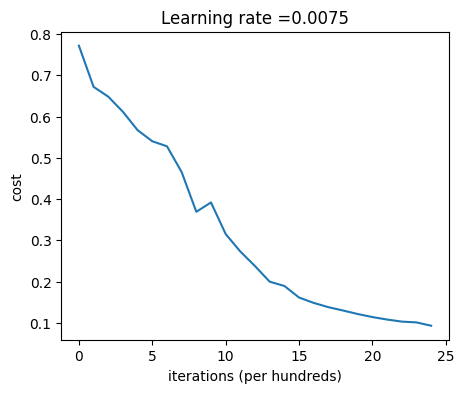

Accuracy: 0.9856459330143539
Accuracy: 0.0


C:\Users\Jachao Computer\AppData\Local\Temp\ipykernel_14984\997068555.py:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print("Accuracy: "  + str(np.sum((p == y)/m)))


In [514]:
layers_dims = [12288, 20, 7, 5, 1]
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)
pred_train = predict(train_x, parameters, y = train_y)
pred_test = predict(test_x, parameters, y = train_y)